In [1]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2

joblib is not installed. Falling back to sequential computation.


In [2]:
dna = md.load('/Users/thor/surfdrive/Data/h-ns/NAR/md/0_highaff/DNA/drytrajs/dry_0.pdb').remove_solvent()
dna = dna.atom_slice(dna.top.select('not element type H'))
dna = md.load('/Users/thor/surfdrive/Projects/pymdna/examples/biomolsim/dna.pdb')
sequence = {res.index:np.array([at.index for at in res._atoms]) for res  in dna.top._residues}
sequence

{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 1: array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40]),
 2: array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60, 61, 62]),
 3: array([63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
        80, 81, 82, 83]),
 4: array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
         97,  98,  99, 100, 101, 102, 103, 104]),
 5: array([105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125]),
 6: array([126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146]),
 7: array([147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167]),
 8: array([168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,


In [3]:
n = 0
view = nv.show_mdtraj(dna.atom_slice(np.concatenate((sequence[n],sequence[23-n]))))
#view = nv.show_mdtraj(dna.atom_slice(dna.top.select('resid 2 3 21 20')))
#view = nv.show_mdtraj(dna)
view.clear()
# view.add_representation('cartoon', selection='backbone')
view.add_representation('ball+stick', selection='nucleic')
view

NGLWidget()

In [4]:

res =   md.load_pdb(f'/Users/thor/surfdrive/Projects/pymdna/pymdna/atomic/BDNA_T.pdb')
#res = dna.atom_slice(dna.top.select('resid 1'))
ref = mdna.ReferenceBase(res)

In [5]:
view = nv.show_mdtraj(res)
view.clear()
view.add_representation('ball+stick', selection='all')
view

NGLWidget()

(-0.7073416754603387,
 0.47664168924093253,
 -0.0558658882975579,
 1.1281174764037134,
 -0.5030937638133764,
 0.3848937597125769)

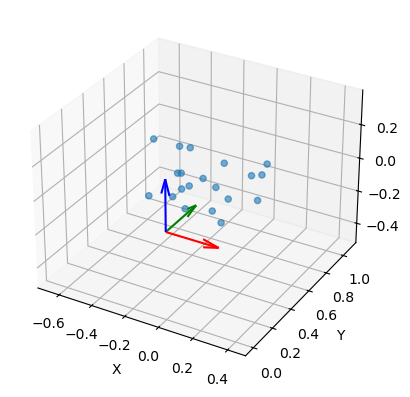

In [6]:
# %matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ref.plot_baseframe(ax=ax,length=0.3)
ax.axis('equal')

In [7]:
from matplotlib.animation import FuncAnimation

In [4]:
C1_coords = ref.C1_coords
C_coords = ref.C_coords
N_coords = ref.N_coords
tau_1 = ref.tau_1
tau_2 = ref.tau_2
d = ref.d

print(d, tau_1, tau_2)

0.4702 2.4692569191365377 -0.9497732723502742


In [5]:
# Calculate the vectors formed by key atoms
# The coords have the shape (n,1,3)
N_C1_vector = C1_coords - N_coords  # Pointing from N to C1'
N_C_vector = C_coords - N_coords  # Pointing from N to C2 or C4

# Calculate normal vector using cross product of vectors formed by key atoms
b_N = np.cross(N_C1_vector, N_C_vector, axis=1)
b_N /= np.linalg.norm(b_N, axis=1, keepdims=True)  # Normalize b_N to have unit length

# Rotate N-C1' vector by angle tau_1 around b_N to get the direction for displacement
N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
R_b_R = mdna.RigidBody.get_rotation_matrix(tau_1 * b_N)

# Displace N along this direction by a distance d to get b_R
rotated_N_C1 = np.einsum('ijk,ik->ij', R_b_R, N_C1_vector)
b_R = N_coords + rotated_N_C1 * d

# Take a unit vector in the N-C1' direction, rotate it around b_N by angle tau_2 to get b_L
R_b_L = mdna.RigidBody.get_rotation_matrix(tau_2 * b_N)
b_L = np.einsum('ijk,ik->ij', R_b_L, N_C1_vector) 

# Calculate b_D using cross product of b_L and b_N
b_D = np.cross(b_L, b_N)
        

MovieWriter ffmpeg unavailable; using Pillow instead.


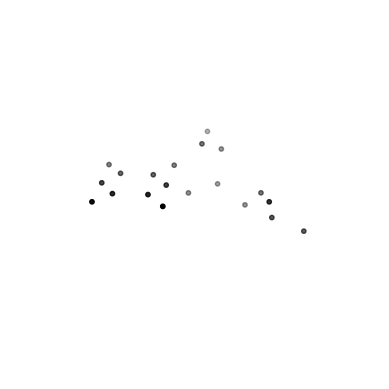

In [6]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)

# Step 1 - plot the atomic reference coordinates
ax.scatter(*res.xyz[0].T,c='k',s=10)
# for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
#     ax.scatter(*coord[0],c='r')

ax.axis('equal')
#ax.view_init(elev=-70., azim=0)

# # Step 2 - plot the vectors formed by key atoms
# ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C1_vector[0,0],N_C1_vector[0,1],N_C1_vector[0,2],color='b',length=0.3, alpha=0.5)
# ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_0.gif')


MovieWriter ffmpeg unavailable; using Pillow instead.


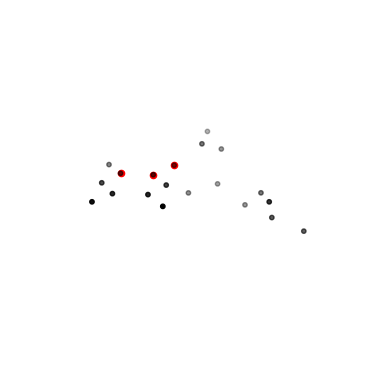

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)

# Step 1 - plot the atomic reference coordinates
ax.scatter(*res.xyz[0].T,c='k',s=10)
for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')

# # Step 2 - plot the vectors formed by key atoms
# ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C1_vector[0,0],N_C1_vector[0,1],N_C1_vector[0,2],color='b',length=0.3, alpha=0.5)
# ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')
ax.axis('equal')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_1.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


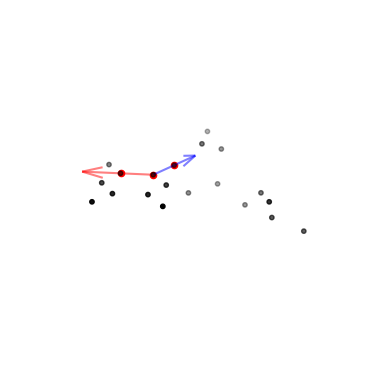

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)

# Step 1 - plot the atomic reference coordinates
ax.scatter(*res.xyz[0].T,c='k',s=10)
for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')

# Step 2 - plot the vectors formed by key atoms
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C1_vector[0,0],N_C1_vector[0,1],N_C1_vector[0,2],color='b',length=0.3, alpha=0.5)
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)


# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')
ax.axis('equal')
# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_2.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


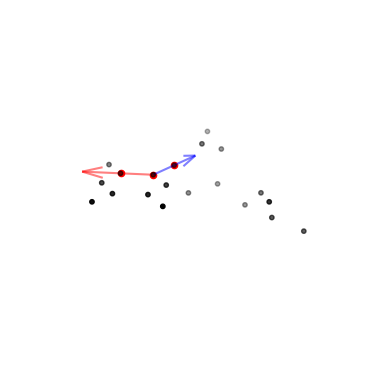

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)

ax.scatter(*res.xyz[0].T,c='k',s=10)

# # Step 1 - plot the atomic reference coordinates
# ax.scatter(*res.xyz[0].T)
# for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
#     ax.scatter(*coord[0],c='r')

for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')

# Step 2 - plot the vectors formed by key atoms
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C1_vector[0,0],N_C1_vector[0,1],N_C1_vector[0,2],color='b',length=0.3, alpha=0.5)
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)


ax.axis('equal')


# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_3.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


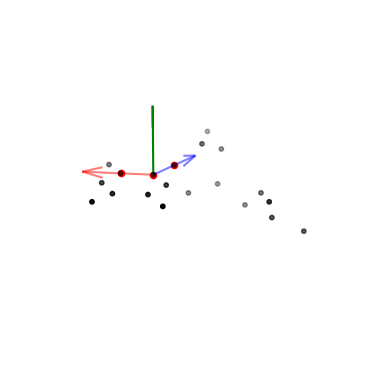

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)
ax.scatter(*res.xyz[0].T,c='k',s=10)

# # Step 1 - plot the atomic reference coordinates
# ax.scatter(*res.xyz[0].T)
# for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
#     ax.scatter(*coord[0],c='r')

for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')

# Step 2 - plot the vectors formed by key atoms
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C1_vector[0,0],N_C1_vector[0,1],N_C1_vector[0,2],color='b',length=0.3, alpha=0.5)
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)

# # Step 3 - plot the normal vector: b_N
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_N[0,0],b_N[0,1],b_N[0,2],color='g',length=0.3)


# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')
ax.axis('equal')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_4.gif')
   

MovieWriter ffmpeg unavailable; using Pillow instead.


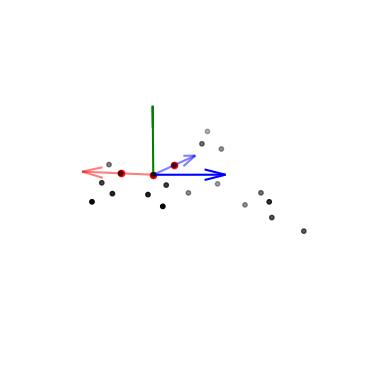

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)

ax.scatter(*res.xyz[0].T,c='k',s=10)
for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')
    
# Step 2 - plot the vectors formed by key atoms
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C1_vector[0,0],N_C1_vector[0,1],N_C1_vector[0,2],color='b',length=0.3, alpha=0.5)
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)

# # Step 3 - plot the normal vector: b_N
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_N[0,0],b_N[0,1],b_N[0,2],color='g',length=0.3)

# Step 5 - plot the rotated N_C vector: b_L
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_L[0,0],b_L[0,1],b_L[0,2],color='blue',length=0.3)

ax.axis('equal')


 # Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_5.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


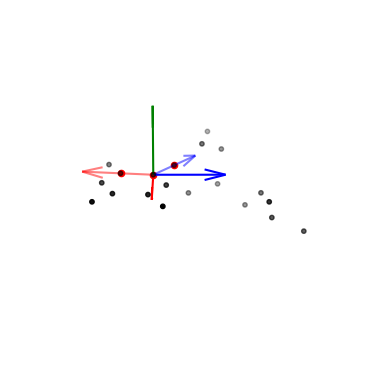

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)

ax.scatter(*res.xyz[0].T,c='k',s=10)
for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')
    
# Step 2 - plot the vectors formed by key atoms
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C1_vector[0,0],N_C1_vector[0,1],N_C1_vector[0,2],color='b',length=0.3, alpha=0.5)
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)

# # Step 3 - plot the normal vector: b_N
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_N[0,0],b_N[0,1],b_N[0,2],color='g',length=0.3)

# Step 5 - plot the rotated N_C vector: b_L
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_L[0,0],b_L[0,1],b_L[0,2],color='blue',length=0.3)

# Step 7 - plot the cross product of b_L and b_N: b_D
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_D[0,0],b_D[0,1],b_D[0,2],color='red',length=0.3)

ax.axis('equal')

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_6.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


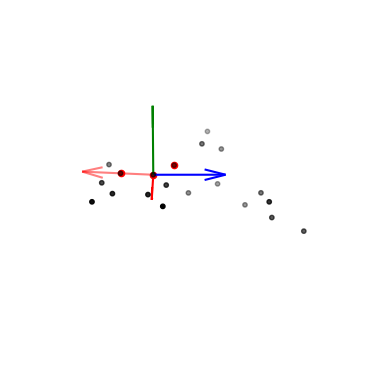

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)


# Step 1 - plot the atomic reference coordinates
ax.scatter(*res.xyz[0].T,c='k',s=10)
for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')

# Old key atom vector
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)

# # Step 3 - plot the normal vector: b_N
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_N[0,0],b_N[0,1],b_N[0,2],color='g',length=0.3)

# Step 5 - plot the rotated N_C vector: b_L
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_L[0,0],b_L[0,1],b_L[0,2],color='blue',length=0.3)

# Step 7 - plot the cross product of b_L and b_N: b_D
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_D[0,0],b_D[0,1],b_D[0,2],color='red',length=0.3)

ax.axis('equal')

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_7.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


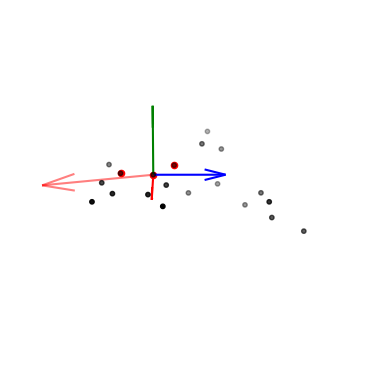

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)


# Step 1 - plot the atomic reference coordinates
ax.scatter(*res.xyz[0].T,c='k',s=10)
for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')

# Old key atom vector
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], rotated_N_C1[0,0]*d,rotated_N_C1[0,1]*d,rotated_N_C1[0,2]*d,color='red',alpha=0.5)

# # Step 3 - plot the normal vector: b_N
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_N[0,0],b_N[0,1],b_N[0,2],color='g',length=0.3)

# Step 5 - plot the rotated N_C vector: b_L
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_L[0,0],b_L[0,1],b_L[0,2],color='blue',length=0.3)

# Step 7 - plot the cross product of b_L and b_N: b_D
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_D[0,0],b_D[0,1],b_D[0,2],color='red',length=0.3)

ax.axis('equal')

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_8.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


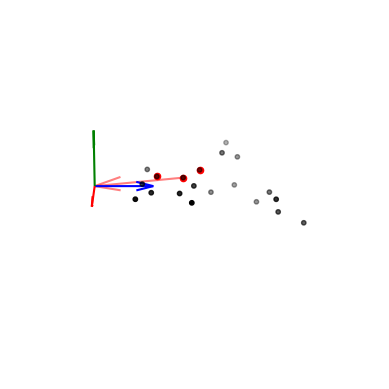

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)


# Step 1 - plot the atomic reference coordinates
ax.scatter(*res.xyz[0].T,c='k',s=10)
for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')


# Old key atom vector
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], rotated_N_C1[0,0]*d,rotated_N_C1[0,1]*d,rotated_N_C1[0,2]*d,color='red',alpha=0.5)

# # Step 3 - plot the normal vector: b_N
ax.quiver(b_R[0][0],b_R[0][1],b_R[0][2], b_N[0,0],b_N[0,1],b_N[0,2],color='g',length=0.3)

# Step 5 - plot the rotated N_C vector: b_L
ax.quiver(b_R[0][0],b_R[0][1],b_R[0][2], b_L[0,0],b_L[0,1],b_L[0,2],color='blue',length=0.3)

# Step 7 - plot the cross product of b_L and b_N: b_D
ax.quiver(b_R[0][0],b_R[0][1],b_R[0][2], b_D[0,0],b_D[0,1],b_D[0,2],color='red',length=0.3)

ax.axis('equal')

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_9.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


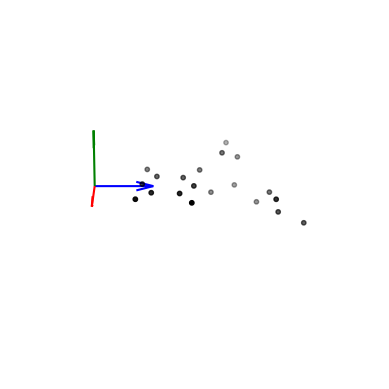

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)


# Step 1 - plot the atomic reference coordinates
ax.scatter(*res.xyz[0].T,c='k',s=10)
# for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
#     ax.scatter(*coord[0],c='r')


# # Old key atom vector
# ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], rotated_N_C1[0,0]*d,rotated_N_C1[0,1]*d,rotated_N_C1[0,2]*d,color='red',alpha=0.5)

# # Step 3 - plot the normal vector: b_N
ax.quiver(b_R[0][0],b_R[0][1],b_R[0][2], b_N[0,0],b_N[0,1],b_N[0,2],color='g',length=0.3)

# Step 5 - plot the rotated N_C vector: b_L
ax.quiver(b_R[0][0],b_R[0][1],b_R[0][2], b_L[0,0],b_L[0,1],b_L[0,2],color='blue',length=0.3)

# Step 7 - plot the cross product of b_L and b_N: b_D
ax.quiver(b_R[0][0],b_R[0][1],b_R[0][2], b_D[0,0],b_D[0,1],b_D[0,2],color='red',length=0.3)

ax.axis('equal')

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Define the update function for animation
def update(angle):
    ax.view_init(elev=20, azim=angle)

# Create an animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 1), interval=20)

# Save the animation as a GIF
ani.save('build_10.gif')

# Mean referene frame

In [8]:
n = 0
basepair = dna.atom_slice(np.concatenate((sequence[n],sequence[23-n])))
view = nv.show_mdtraj(basepair)
#view = nv.show_mdtraj(dna.atom_slice(dna.top.select('resid 2 3 21 20')))
#view = nv.show_mdtraj(dna)
view.clear()
# view.add_representation('cartoon', selection='backbone')
view.add_representation('ball+stick', selection='nucleic')
view

NGLWidget()

In [6]:
ref1 = mdna.ReferenceBase(dna.atom_slice(sequence[n]))
ref2 = mdna.ReferenceBase(dna.atom_slice(sequence[23-n]))

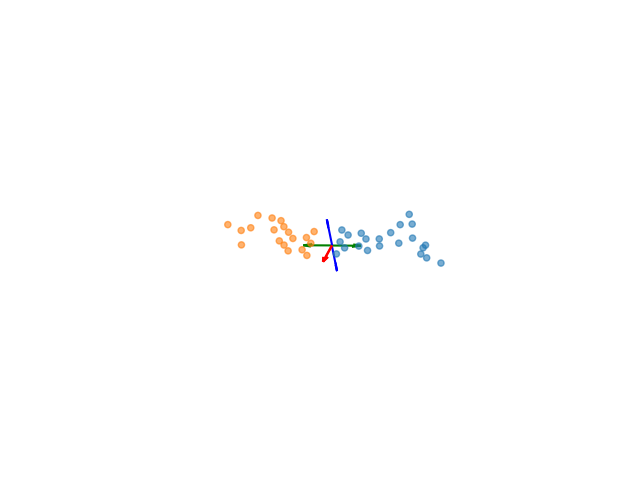

In [24]:
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ref1.plot_baseframe(ax=ax,length=0.3)
ref2.plot_baseframe(ax=ax,length=0.3)

ax.axis('equal')

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.view_init(elev=-60, azim=-170)

(2.6022949695587156,
 4.868405055999756,
 -1.143405032157898,
 1.122705054283142,
 -0.6934912890195846,
 1.0060912758111953)

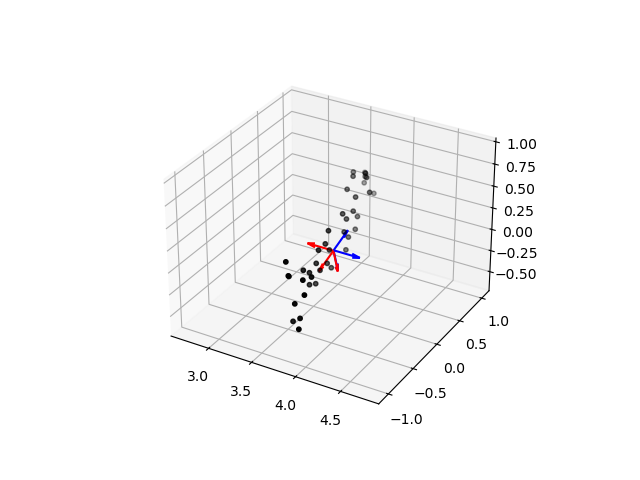

In [51]:
def plot_frame(ax, ref, length=0.3):
        origin = ref.b_R[0]
        ax.quiver(origin[0], origin[1], origin[2], 
                ref.b_L[0][0], ref.b_L[0][1], ref.b_L[0][2], 
                color='r', length=length, normalize=True)
        ax.quiver(origin[0], origin[1], origin[2], 
                ref.b_D[0][0], ref.b_D[0][1], ref.b_D[0][2], 
                color='g', length=length, normalize=True)
        ax.quiver(origin[0], origin[1], origin[2], 
                ref.b_N[0][0], ref.b_N[0][1], ref.b_N[0][2], 
                color='b', length=length, normalize=True)

ul, vl, wl = ref1.b_D[0], ref1.b_L[0], ref1.b_N[0]
ur, vr, wr = ref2.b_D[0], ref2.b_L[0], ref2.b_N[0]

origin1 = ref1.b_R[0]
origin2 = ref2.b_R[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot quiver of the first base
ax.quiver(*origin1, *ul, color='r',length=0.3)
ax.quiver(*origin1, *vl, color='r',length=0.3)
ax.quiver(*origin1, *wl, color='r',length=0.3)
ax.quiver(*origin2, *ur, color='b',length=0.3)
ax.quiver(*origin2, *vr, color='b',length=0.3)
ax.quiver(*origin2, *wr, color='b',length=0.3)
ax.scatter(basepair.xyz[0,:,0],basepair.xyz[0,:,1],basepair.xyz[0,:,2],c='k',s=10)
ax.axis('equal')

Invalid Trace!
[[-0.9999959   0.00283203  0.        ]
 [ 0.00283203  0.9999959   0.        ]
 [ 0.          0.         -1.        ]]
(3, 3) (3, 3, 3) (3, 3)


/Users/thor/surfdrive/Projects/pymdna/pymdna/utils.py:54: RuntimeWarning: invalid value encountered in divide
  omega_normalized = np.where(omega_norm != 0, omega / omega_norm, omega)


(2.6022949695587156,
 4.868405055999756,
 -1.143405032157898,
 1.122705054283142,
 -0.6934912890195846,
 1.0060912758111953)

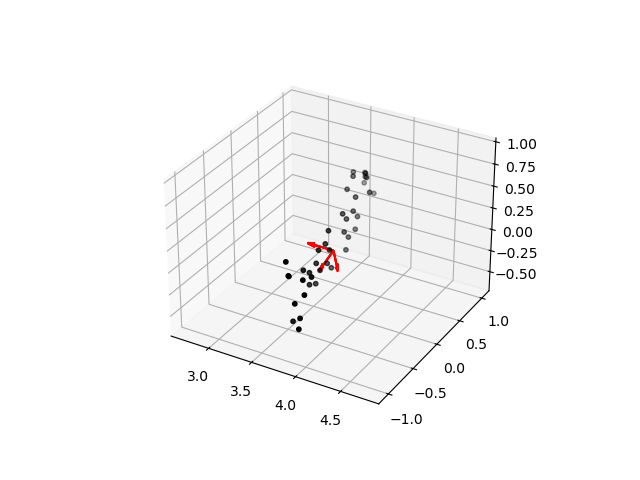

In [82]:
b1 = np.array([ul,vl,wl]).T
b2 = np.array([ur,vr,wr]).T

# Calculate the rotation matrix
R = np.matmul(b2.T, b1)
angle = mdna.RigidBody.extract_omega_values(R)
halfR = mdna.RigidBody.get_rotation_matrix(angle/2)
print(angle.shape, halfR.shape,R.shape)
midframe = np.matmul(halfR, b1)
midorigin  = (origin1+origin2)/2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(*midorigin, *midframe[0], color='r',length=0.3)
ax.quiver(*midorigin, *midframe[1], color='r',length=0.3)
ax.quiver(*midorigin, *midframe[2], color='r',length=0.3)
ax.scatter(basepair.xyz[0,:,0],basepair.xyz[0,:,1],basepair.xyz[0,:,2],c='k',s=10)
ax.axis('equal')


In [1]:
%matplotlib ipympl

nuc = mdna.NucleicFrames(basepair)
frames = nuc.mean_reference_frames[0][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ref1.plot_baseframe(ax=ax,length=0.3,frame=False)
ref2.plot_baseframe(ax=ax,length=0.3,frame=False)
ax.quiver(*frames[0], *frames[1:], color='k',length=0.3)

ax.axis('equal')

# Remove axis labels and grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.grid(False)
ax.axis('off')

# Make the panes transparent
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the gridlines and border
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.view_init(elev=-60, azim=-170)

NameError: name 'mdna' is not defined

(2.6022949695587156,
 4.868405055999756,
 -1.143405032157898,
 1.122705054283142,
 -0.6934912890195846,
 1.0060912758111953)

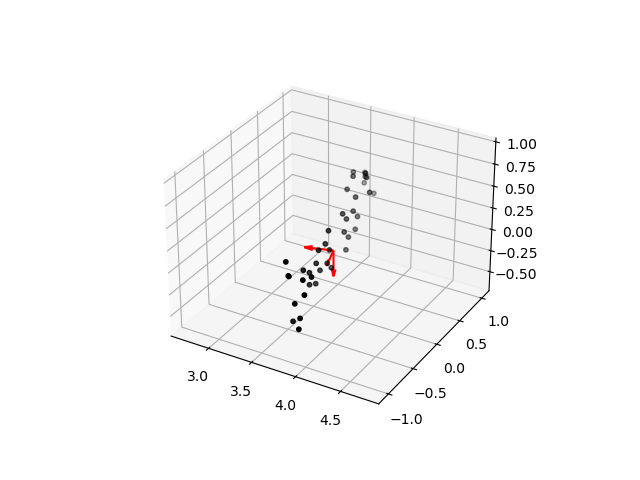

In [88]:
nuc = mdna.NucleicFrames(basepair)
frames = nuc.mean_reference_frames[0][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(*frames[0], *frames[1:], color='r',length=0.3)
ax.scatter(basepair.xyz[0,:,0],basepair.xyz[0,:,1],basepair.xyz[0,:,2],c='k',s=10)
ax.axis('equal')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

N_C1_vector /= np.linalg.norm(N_C1_vector, axis=1, keepdims=True)
N_C_vector /= np.linalg.norm(N_C_vector, axis=1, keepdims=True)

# Step 1 - plot the atomic reference coordinates
ax.scatter(*res.xyz[0].T)
for coord in [N_coords,C1_coords,C_coords]:##,b_R[0],b_L[0],b_D[0]]:
    ax.scatter(*coord[0],c='r')

# Step 2 - plot the vectors formed by key atoms
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C1_vector[0,0],N_C1_vector[0,1],N_C1_vector[0,2],color='b',length=0.3, alpha=0.5)
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], N_C_vector[0,0],N_C_vector[0,1],N_C_vector[0,2],color='r',length=0.3, alpha=0.5)

# # Step 3 - plot the normal vector: b_N
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_N[0,0],b_N[0,1],b_N[0,2],color='g',length=0.3)

# Step 4 - plot the rotated N-C1' vector: rotated_N_C1
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], rotated_N_C1[0,0],rotated_N_C1[0,1],rotated_N_C1[0,2],color='r',length=0.3)

# Step 5 - plot the rotated N_C vector: b_L
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_L[0,0],b_L[0,1],b_L[0,2],color='darkred',length=0.3)

# Step 6 - multiply rotated_N_C1 by d to get b_R
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], rotated_N_C1[0,0]*d,rotated_N_C1[0,1]*d,rotated_N_C1[0,2]*d,color='orange',length=0.3)

# Step 7 - plot the cross product of b_L and b_N: b_D
ax.quiver(N_coords[0][0],N_coords[0][1],N_coords[0][2], b_D[0,0],b_D[0,1],b_D[0,2],color='purple',length=0.3)


ax.axis('equal')

# Groove Widths